# Predictive Analysis

In this phase we face the problem of predicting if a customer is an high/medium/low-spending one.  
In order to do so we'll define a suitable customer profile, compute the labels on it and use it to train models for performing a predictive analysis. The notebook ends with a comparison between the diffetent models used.

In [1]:
#import the module in the parent folder
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import mylib
from mylib.dataloading import *
from mylib import utilities

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns; sns.set()

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from scipy.stats import randint as sp_randint
import random
import statistics 

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from tensorflow import keras

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
plt.style.use('seaborn')
params = {
    'figure.figsize': (15, 5),
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.titlesize': 'x-large',
}
plt.rcParams.update(params)

# Preparation phase

In this phase we set up the environment for the classification by defining constants, useful functions and selecting the right attributes.

In [7]:
# Useful costants
TEST_SIZE = 0.3
# Stratified K-fold parameter
K = 4
# Score function 
score_fun = "f1_weighted"
score_metrics = ["f1_weighted", "accuracy", "f1_macro", "f1_micro", "precision_weighted", "recall_weighted"]

In [8]:
df = load_customer_data(CLUSTER_PROFILE_DATASET_NAME)
df.info()
df_prv = df.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3702 entries, 0 to 3754
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CustomerID     3702 non-null   int64  
 1   Country        3702 non-null   object 
 2   I              3702 non-null   int64  
 3   Iu             3702 non-null   int64  
 4   Imax           3702 non-null   int64  
 5   Imin           3702 non-null   int64  
 6   E              3702 non-null   float64
 7   MBP            3702 non-null   object 
 8   Recency        3702 non-null   int64  
 9   Frequency      3702 non-null   int64  
 10  MonetaryValue  3702 non-null   float64
 11  FirstPurchase  3702 non-null   int64  
 12  Cluster        3702 non-null   int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 404.9+ KB


We separate the indicators used to create the lables from the ones that will be used for prediction.
The labels will be computed on the `X_indicators`. 

In [9]:
indicators = ["I", "Iu", "Imax", "Imin", "E", "Recency", "Frequency", "MonetaryValue", "FirstPurchase"]
X_indicators = ["I", "Iu", "Imax", "Imin", "E", "FirstPurchase"]
data = df[indicators]
data.head()

I  Iu  Imax  Imin         E  Recency  Frequency  MonetaryValue  \
0  542  43   200    18  5.176319        1          7        1742.36   
1  124  19   124   124  4.247928       18          1         345.92   
2   54   5    54    54  2.321928      309          1         118.50   
3  131  17    35    12  3.936180       35          6         395.83   
4    6   1     6     6  0.000000      203          1          17.70   

   FirstPurchase  
0            366  
1             18  
2            309  
3            296  
4            203

In [10]:
rc = data.Recency
fr = data.Frequency
mv = data.MonetaryValue

Text(0.5, 1.0, 'Monetary value')

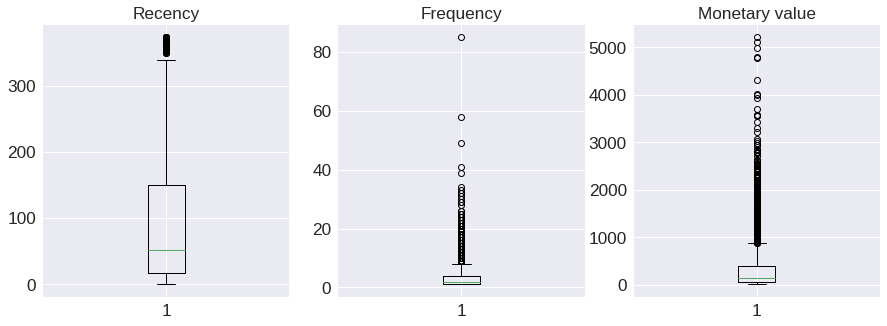

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.boxplot(rc)
ax1.set_title("Recency")
ax2.boxplot(fr)
ax2.set_title("Frequency")
ax3.boxplot(mv)
ax3.set_title("Monetary value")

In [12]:
rfm = data[["Recency", "Frequency", "MonetaryValue"]].copy()

In [13]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
display(quantiles)

Recency  Frequency  MonetaryValue
0.25     18.0        1.0        68.0250
0.50     52.0        2.0       153.8000
0.75    150.0        4.0       396.4075

We assign a score from 0 to 4 depending on the quantile the customer belongs to.

In [14]:
def RScore(x, p, d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

def FMScore(x, p, d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [15]:
rfm_segmentation = rfm
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency', quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency', quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['MonetaryValue'].apply(FMScore, args=('MonetaryValue', quantiles,))
display(rfm_segmentation.head())

Recency  Frequency  MonetaryValue  R_Quartile  F_Quartile  M_Quartile
0        1          7        1742.36           4           4           4
1       18          1         345.92           4           1           3
2      309          1         118.50           1           1           2
3       35          6         395.83           3           4           3
4      203          1          17.70           1           1           1

We add the RFMscore computed as the average of the RFM quartiles.

In [16]:
rfm_segmentation['RFMscore'] = (rfm_segmentation.R_Quartile \
                            + rfm_segmentation.F_Quartile \
                            + rfm_segmentation.M_Quartile) / 3
rfm_segmentation.head()

Recency  Frequency  MonetaryValue  R_Quartile  F_Quartile  M_Quartile  \
0        1          7        1742.36           4           4           4   
1       18          1         345.92           4           1           3   
2      309          1         118.50           1           1           2   
3       35          6         395.83           3           4           3   
4      203          1          17.70           1           1           1   

   RFMscore  
0  4.000000  
1  2.666667  
2  1.333333  
3  3.333333  
4  1.000000

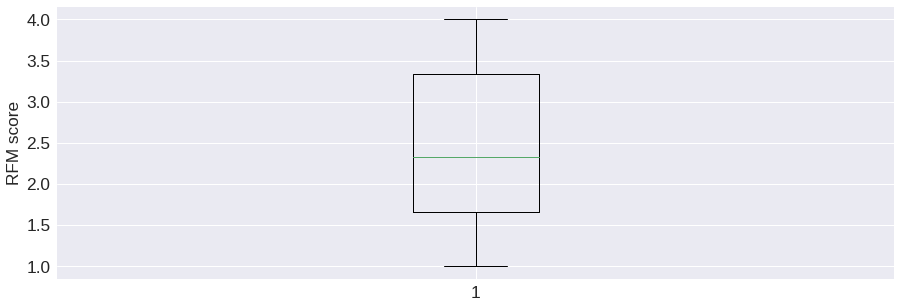

In [17]:
plt.boxplot(rfm_segmentation['RFMscore'])
plt.ylabel("RFM score")
plt.show()

We add the spending attribute to the dataset computed as a quantile-based discretization function on the RFM score.

In [18]:
data["Spending"] = pd.qcut(rfm_segmentation["RFMscore"], 3, labels=["low", "med", "high"])

/home/fabsam/miniconda3/envs/py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
df_annotated = data.copy()
df_annotated["CustomerID"] = df.CustomerID
#save the annotated dataset
save_customer_dataset(df_annotated, ANNOTATED_CUSTOMER_PROFILE)

dataset saved to /home/fabsam/Documenti/university/masterDegree/2_year/DM/DM_project/datasets/customer/annotated_customer_profile.csv


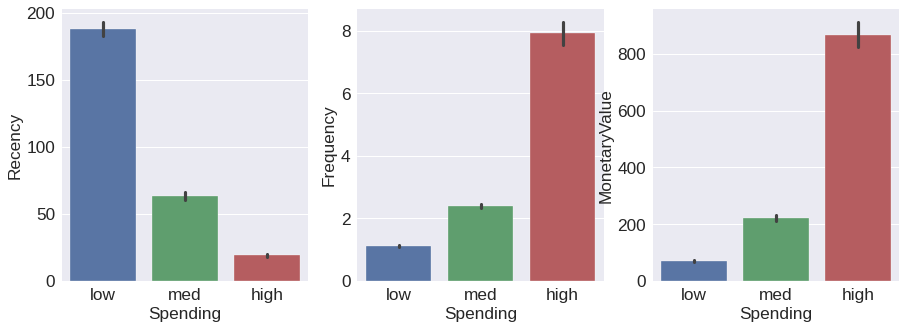

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
sns.barplot(data=data, x="Spending", y="Recency", ax=ax1)
sns.barplot(data=data, x="Spending", y="Frequency", ax=ax2)
sns.barplot(data=data, x="Spending", y="MonetaryValue", ax=ax3)
plt.show()

<AxesSubplot:xlabel='Spending', ylabel='Count'>

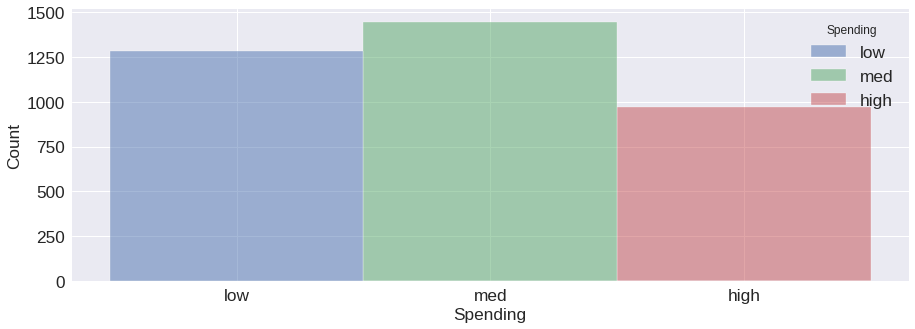

In [21]:
sns.histplot(data, x="Spending", hue="Spending")

In [22]:
dataset = data.copy()

In [23]:
Y = dataset.pop('Spending')

In [24]:
X = dataset.drop(["Recency", "Frequency", "MonetaryValue"], axis=1)

In [25]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=TEST_SIZE)

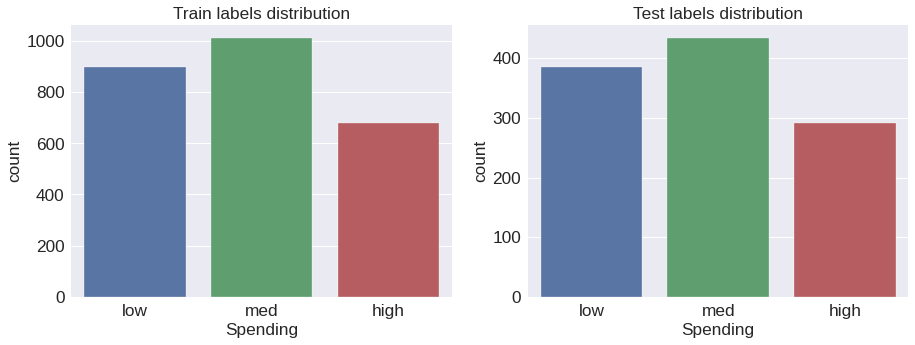

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2)
sns.countplot(Y_train, ax=ax1)
ax1.set_title("Train labels distribution")
sns.countplot(Y_test, ax=ax2)
ax2.set_title("Test labels distribution")
plt.show()

In [27]:
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

def scale_data(X_train, X_test, scaler):
    return scaler.transform(X_train), scaler.transform(X_test)

We decided to define the class weights based on the training labels distribution

In [28]:
l_weights = [round((class_weight / len(Y_train)), 2) for class_weight in list(Y_train.value_counts())]

In [29]:
labels = ["med", "low", "high"]
class_weights = {}
for l, w in zip(labels, l_weights):
    class_weights[l] = w
display(class_weights)

{'med': 0.39, 'low': 0.35, 'high': 0.26}

In [30]:
def grid_search(estimator, param_dict, scoring, X_train, Y_train, cv=5):
    grid_search = GridSearchCV(
        estimator, 
        param_grid=param_dict,
        scoring=scoring,
        cv=cv
    )
    #run the grid search
    grid_search.fit(X_train, Y_train)
    return grid_search, grid_search.best_estimator_

def random_search(estimator, param_dict, scoring, X_train, Y_train, n_iter=32, random_state=42, cv=5):
    random_search = RandomizedSearchCV(
        estimator, 
        param_distributions=param_dict,
        scoring=scoring,
        n_iter=n_iter,
        random_state=random_state,
        cv=cv
    )
    #run the random search
    random_search.fit(X_train, Y_train)
    return random_search, random_search.best_estimator_

def print_cross_validation(model, model_name, X_train, Y_train, K=K, score_metrics=score_metrics):
    scores = cross_validate(model, X_train, Y_train, cv=K, scoring=score_metrics, return_train_score= True)
    model_scores_val = {}
    model_scores_train = {}
    model_scores_others = {}
    K_scores = []
    for k, v in scores.items():
        s = statistics.mean(v)
        if k.startswith("test_"):
            k = k.replace("test_", "val_")
            model_scores_val[k] = s
            K_scores.append(v)
        elif k.startswith("train_"):
            model_scores_train[k] = s
        else:
            model_scores_others[k] = s
        print("(Mean) {:<40}: {}".format(k, s))
    
    bplot = plt.boxplot(K_scores, labels=[k.replace("val_", "") for k in model_scores_val.keys()], patch_artist=True)
    colors = ['lightcoral', 'lightcyan', 'lightblue', 'lightgreen', 'lightsteelblue', 'sandybrown', 'tab:olive']
    plt.title(model_name + " validation results")
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    model_scores_val["Model"] = model_name
    model_scores_train["Model"] = model_name
    model_scores_others["Model"] = model_name
    return model_scores_val, model_scores_train, model_scores_others

In [31]:
X_train_scal, X_test_scal = scale_data(X_train, X_test, scaler)

# Models

## Decision Tree

In [32]:
random.seed(42)

In [33]:
#define the parameters' values you want to try
param_dict = {"max_depth": [2, 3, 5, 6, 7, 10, 12, None],
              "max_features": random.sample(range(1, len(X_indicators)), 3),
              "min_samples_split": random.sample(range(2, 40), 15),
              "min_samples_leaf": random.sample(range(1, 20), 10),
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, class_weights]}
dt = DecisionTreeClassifier()
search_dt, dt_opt = random_search(dt, param_dict, score_fun, X_train, Y_train, cv=K, n_iter=128)

In [34]:
print("Best hyperparameters configuration")
display(search_dt.best_params_)
print("Best score: ", search_dt.best_score_)

Best hyperparameters configuration


{'min_samples_split': 18,
 'min_samples_leaf': 18,
 'max_features': 5,
 'max_depth': 12,
 'criterion': 'entropy',
 'class_weight': {'med': 0.39, 'low': 0.35, 'high': 0.26}}

Best score:  0.872613054247492


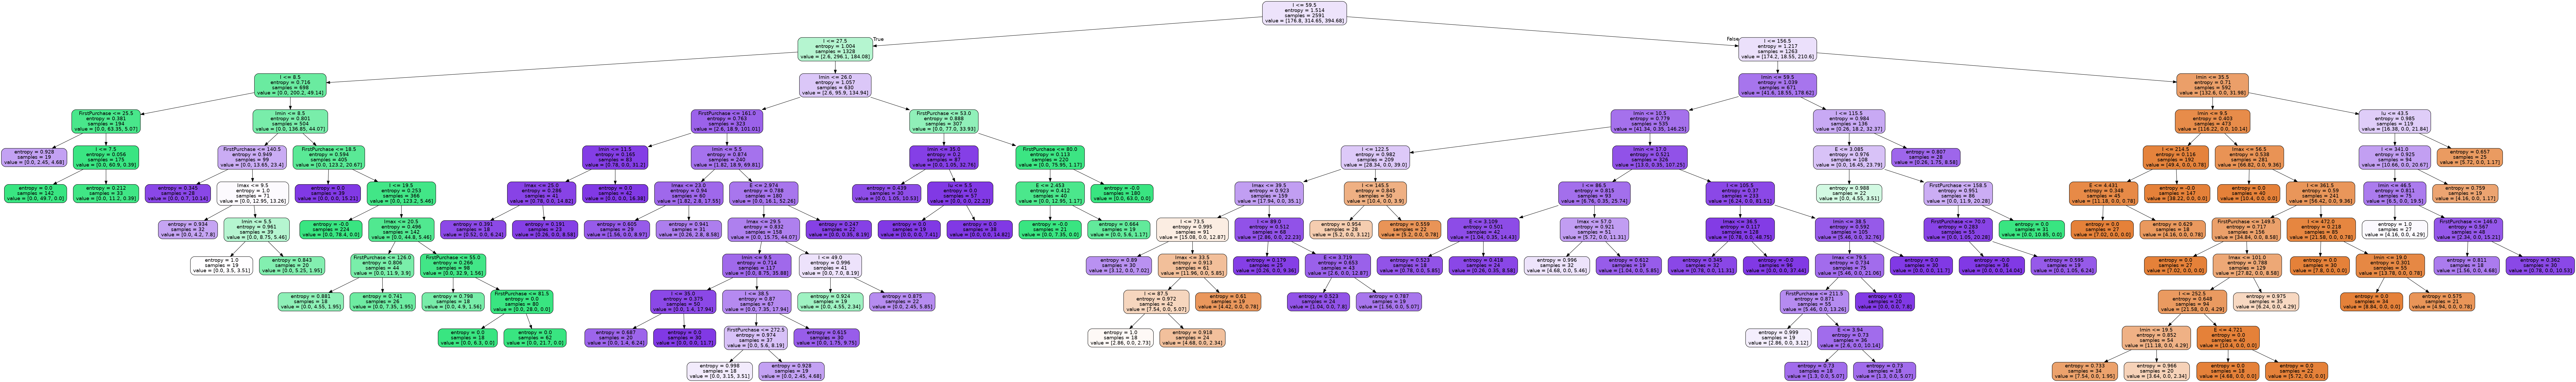

In [35]:
#visualize the actual decision tree obtained 
import pydotplus 
from IPython.display import Image  
dot_data = tree.export_graphviz(
    dt_opt, out_file=None, 
    feature_names=X_indicators,  
    filled=True, rounded=True
)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

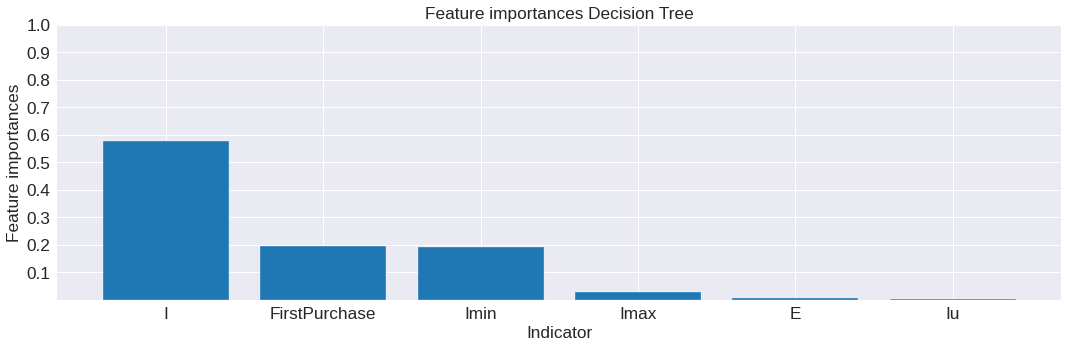

In [36]:
feature_importances_dt = pd.DataFrame({
    "Indicator": X_train.columns,
    "FeatureImportance": dt_opt.feature_importances_
})
feature_importances_dt = feature_importances_dt.sort_values("FeatureImportance", ascending=False)

plt.bar(feature_importances_dt["Indicator"], feature_importances_dt["FeatureImportance"],
        color="tab:blue", align="center")

plt.xlabel("Indicator")
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.ylabel("Feature importances")
plt.title("Feature importances Decision Tree")
plt.tight_layout()
plt.show()

(Mean) fit_time                                : 0.015173375606536865
(Mean) score_time                              : 0.03761559724807739
(Mean) val_f1_weighted                         : 0.8621298757180871
(Mean) train_f1_weighted                       : 0.8879267783048612
(Mean) val_accuracy                            : 0.8614420544965367
(Mean) train_accuracy                          : 0.8874298023505292
(Mean) val_f1_macro                            : 0.8625377574625513
(Mean) train_f1_macro                          : 0.8879558532222307
(Mean) val_f1_micro                            : 0.8614420544965367
(Mean) train_f1_micro                          : 0.8874298023505293
(Mean) val_precision_weighted                  : 0.8663569429026275
(Mean) train_precision_weighted                : 0.8904274209170023
(Mean) val_recall_weighted                     : 0.8614420544965367
(Mean) train_recall_weighted                   : 0.8874298023505292


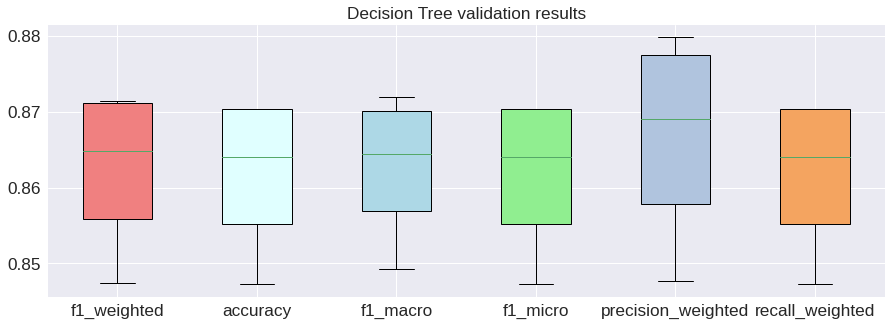

In [37]:
dt_scores_val, dt_scores_train, dt_scores_others = print_cross_validation(dt_opt, "Decision Tree", X_train, Y_train)

In [38]:
train_pred_dt = dt_opt.predict(X_train)
test_pred_dt = dt_opt.predict(X_test)
print(metrics.classification_report(Y_test, test_pred_dt))

              precision    recall  f1-score   support

        high       0.86      0.75      0.80       292
         low       0.91      0.90      0.90       385
         med       0.76      0.84      0.80       434

    accuracy                           0.84      1111
   macro avg       0.84      0.83      0.83      1111
weighted avg       0.84      0.84      0.84      1111



<AxesSubplot:>

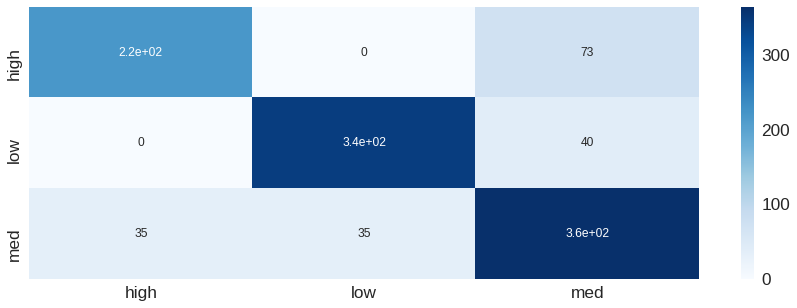

In [39]:
cf_matrix_dt = metrics.confusion_matrix(Y_test, test_pred_dt)
df_cm_dt = pd.DataFrame(cf_matrix_dt, columns=np.unique(Y_test), index = np.unique(Y_test))
sns.heatmap(df_cm_dt, annot=True, cmap='Blues')

## Naive Bayes

In [40]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, Y_train)

GaussianNB()

In [41]:
# gaussian naive bayes predictions on the test set
test_pred_gnb = gnb.predict(X_test)
print(metrics.classification_report(Y_test, test_pred_gnb))

              precision    recall  f1-score   support

        high       0.85      0.67      0.75       292
         low       0.64      0.89      0.75       385
         med       0.61      0.48      0.54       434

    accuracy                           0.67      1111
   macro avg       0.70      0.68      0.68      1111
weighted avg       0.68      0.67      0.67      1111



(Mean) fit_time                                : 0.010078072547912598
(Mean) score_time                              : 0.031679749488830566
(Mean) val_f1_weighted                         : 0.6684671952611723
(Mean) train_f1_weighted                       : 0.6725208542588794
(Mean) val_accuracy                            : 0.6769533411567157
(Mean) train_accuracy                          : 0.6806883261428066
(Mean) val_f1_macro                            : 0.6805496963943924
(Mean) train_f1_macro                          : 0.6844679025975958
(Mean) val_f1_micro                            : 0.6769533411567157
(Mean) train_f1_micro                          : 0.6806883261428066
(Mean) val_precision_weighted                  : 0.6896492025201062
(Mean) train_precision_weighted                : 0.6914946622436107
(Mean) val_recall_weighted                     : 0.6769533411567157
(Mean) train_recall_weighted                   : 0.6806883261428066


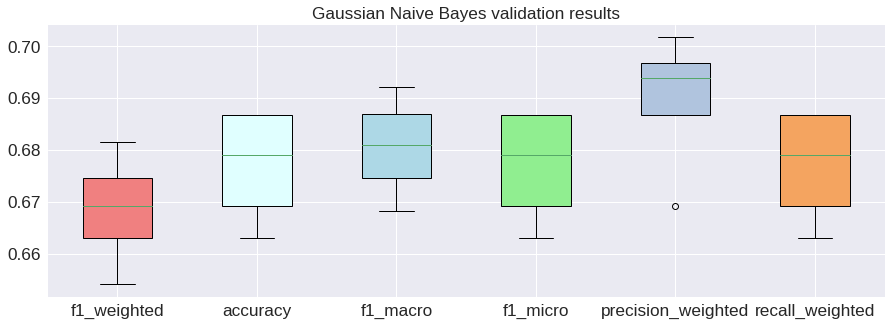

In [42]:
gnb_scores_val, gnb_scores_train, gnb_scores_others = print_cross_validation(gnb, "Gaussian Naive Bayes", X_train, Y_train)

<AxesSubplot:>

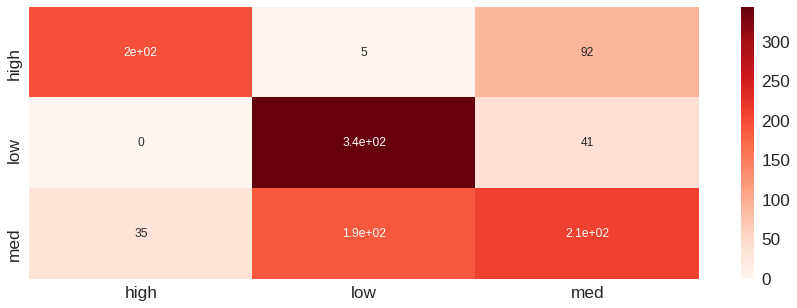

In [43]:
cf_matrix_gnb = metrics.confusion_matrix(Y_test, test_pred_gnb)
df_cm_gnb = pd.DataFrame(cf_matrix_gnb, columns=np.unique(Y_test), index = np.unique(Y_test))
sns.heatmap(df_cm_gnb, annot=True, cmap='Reds')

## Random Forest

In [44]:
random.seed(42)

In [45]:
#define the parameters' values you want to try
param_dict = {"max_depth": [2, 3, 5, 6, 7, 10, 12, None],
              "n_estimators": [10, 30, 100],
              "max_features": random.sample(range(1, len(X_indicators)), 3),
              "min_samples_split": random.sample(range(2, 40), 15),
              "min_samples_leaf": random.sample(range(1, 20), 10),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight":['balanced', None, class_weights]}
rf = RandomForestClassifier()
search_rf, rf_opt = random_search(rf, param_dict, score_fun, X_train, Y_train, cv=K, n_iter=32)

In [46]:
print("Best hyperparameters configuration")
display(search_rf.best_params_)
print(search_rf.best_score_)

Best hyperparameters configuration


{'n_estimators': 100,
 'min_samples_split': 17,
 'min_samples_leaf': 8,
 'max_features': 5,
 'max_depth': 12,
 'criterion': 'gini',
 'class_weight': None,
 'bootstrap': True}

0.8840274711285685


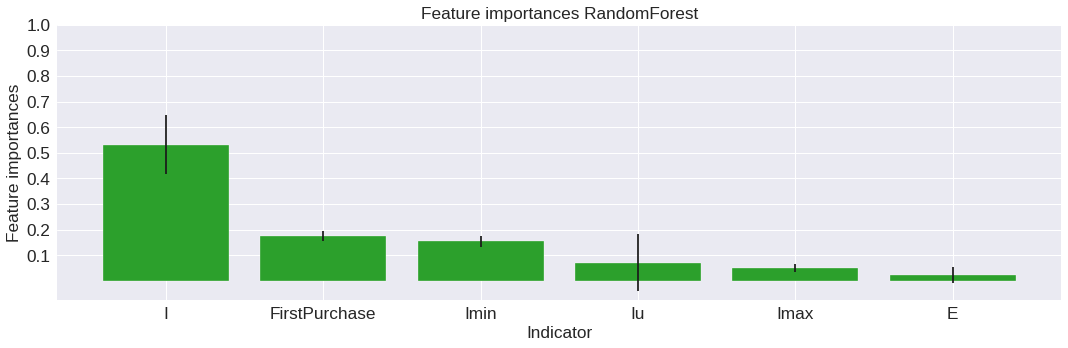

In [47]:
std = np.std([tree.feature_importances_ for tree in rf_opt.estimators_], axis=0)
feature_importances_rf = pd.DataFrame({
    "Indicator": X_train.columns,
    "FeatureImportance": rf_opt.feature_importances_,
    "Std": std
})
feature_importances_rf = feature_importances_rf.sort_values("FeatureImportance", ascending=False)

plt.bar(feature_importances_rf["Indicator"], feature_importances_rf["FeatureImportance"],
        color="tab:green", yerr=feature_importances_rf["Std"], align="center")

plt.xlabel("Indicator")
plt.ylabel("Feature importances")
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.title("Feature importances RandomForest")
plt.tight_layout()
plt.show()

(Mean) fit_time                                : 0.609988272190094
(Mean) score_time                              : 0.06964081525802612
(Mean) val_f1_weighted                         : 0.8840259602959064
(Mean) train_f1_weighted                       : 0.924941686364661
(Mean) val_accuracy                            : 0.883438758181159
(Mean) train_accuracy                          : 0.9246103984123656
(Mean) val_f1_macro                            : 0.8840570552781531
(Mean) train_f1_macro                          : 0.9246812898426773
(Mean) val_f1_micro                            : 0.883438758181159
(Mean) train_f1_micro                          : 0.9246103984123656
(Mean) val_precision_weighted                  : 0.8866135784743772
(Mean) train_precision_weighted                : 0.9260260340889419
(Mean) val_recall_weighted                     : 0.883438758181159
(Mean) train_recall_weighted                   : 0.9246103984123656


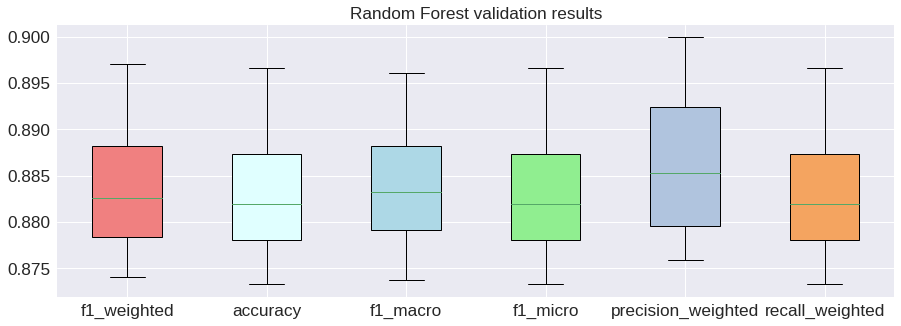

In [48]:
rf_scores_val, rf_scores_train, rf_scores_others = print_cross_validation(rf_opt, "Random Forest", X_train, Y_train)

In [49]:
train_pred_rf = rf_opt.predict(X_train)
test_pred_rf = rf_opt.predict(X_test)
print(metrics.classification_report(Y_test, test_pred_dt))

              precision    recall  f1-score   support

        high       0.86      0.75      0.80       292
         low       0.91      0.90      0.90       385
         med       0.76      0.84      0.80       434

    accuracy                           0.84      1111
   macro avg       0.84      0.83      0.83      1111
weighted avg       0.84      0.84      0.84      1111



<AxesSubplot:>

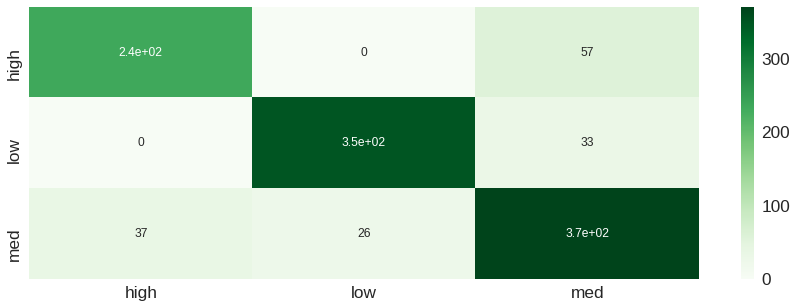

In [50]:
cf_matrix_rf = metrics.confusion_matrix(Y_test, test_pred_rf)
df_cm_rf = pd.DataFrame(cf_matrix_rf, columns=np.unique(Y_test), index = np.unique(Y_test))
sns.heatmap(df_cm_rf, annot=True, cmap='Greens')

## K-Nearest Neighbors

In [51]:
random.seed(42)

In [52]:
#define the parameters' values you want to try
param_dict = {"n_neighbors": [2, 4, 6, 8, 10, 12, 15],
              "algorithm": ["auto", "ball_tree", "kd_tree"],
              "metric": ["minkowski", "manhattan"],
              "weights":["uniform", "distance"] }
knn = KNeighborsClassifier()
search_knn, knn_opt = random_search(knn, param_dict, score_fun, X_train_scal, Y_train, cv=K, n_iter=32)

In [53]:
print("Best hyperparameters configuration")
display(search_knn.best_params_)
print(search_knn.best_score_)

Best hyperparameters configuration


{'weights': 'distance',
 'n_neighbors': 15,
 'metric': 'manhattan',
 'algorithm': 'ball_tree'}

0.8452092185968417


(Mean) fit_time                                : 0.005949497222900391
(Mean) score_time                              : 0.05597048997879028
(Mean) val_f1_weighted                         : 0.8452092185968417
(Mean) train_f1_weighted                       : 0.9997427426566939
(Mean) val_accuracy                            : 0.8452270211994581
(Mean) train_accuracy                          : 0.999742732167176
(Mean) val_f1_macro                            : 0.8469743628801527
(Mean) train_f1_macro                          : 0.9997666771786117
(Mean) val_f1_micro                            : 0.8452270211994581
(Mean) train_f1_micro                          : 0.999742732167176
(Mean) val_precision_weighted                  : 0.8461705411286206
(Mean) train_precision_weighted                : 0.9997431130228722
(Mean) val_recall_weighted                     : 0.8452270211994581
(Mean) train_recall_weighted                   : 0.999742732167176


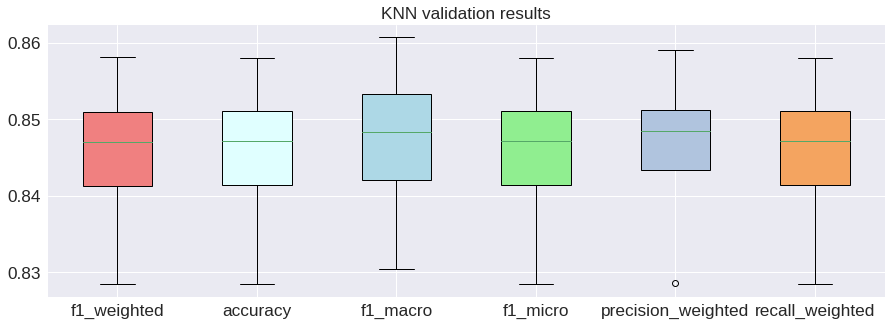

In [54]:
knn_scores_val, knn_scores_train, knn_scores_others = print_cross_validation(knn_opt, "KNN", X_train_scal, Y_train)

In [55]:
train_pred_knn = knn_opt.predict(X_train_scal)
test_pred_knn = knn_opt.predict(X_test_scal)
print(metrics.classification_report(Y_test, test_pred_knn))

              precision    recall  f1-score   support

        high       0.86      0.79      0.83       292
         low       0.88      0.93      0.91       385
         med       0.81      0.81      0.81       434

    accuracy                           0.85      1111
   macro avg       0.85      0.85      0.85      1111
weighted avg       0.85      0.85      0.85      1111



<AxesSubplot:>

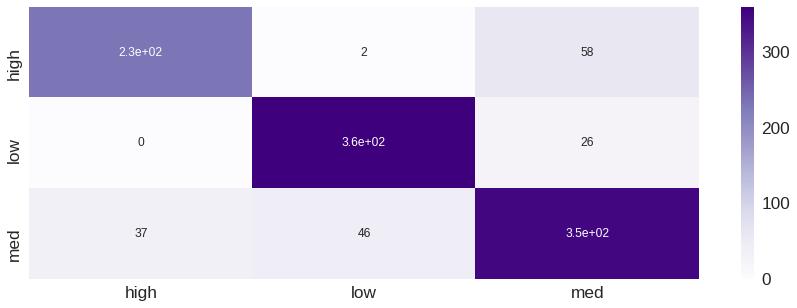

In [56]:
cf_matrix_knn = metrics.confusion_matrix(Y_test, test_pred_knn)
df_cm_knn = pd.DataFrame(cf_matrix_knn, columns=np.unique(Y_test), index = np.unique(Y_test))
sns.heatmap(df_cm_knn, annot=True, cmap='Purples')

## Support Vector Machine

In [57]:
random.seed(42)

In [58]:
exp = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4, 1e5]
param_dict = [
    {
        'kernel': ['rbf'], 
        'gamma': exp,
        'C': exp
    },
    {
        'kernel': ['linear'], 
        'C': exp
    }
]
svm = SVC(probability=True)
search_svm, svm_opt = random_search(svm, param_dict, score_fun, X_train_scal, Y_train, cv=K, n_iter=32)

In [59]:
print("Best hyperparameters configuration")
display(search_svm.best_params_)
print(search_svm.best_score_)

Best hyperparameters configuration


{'kernel': 'rbf', 'gamma': 0.1, 'C': 100.0}

0.8733988066457347


In [60]:
test_pred_svm = svm_opt.predict(X_test_scal)
#compute the performance of the model
print(metrics.classification_report(Y_test, test_pred_svm))

              precision    recall  f1-score   support

        high       0.87      0.83      0.85       292
         low       0.92      0.93      0.93       385
         med       0.83      0.85      0.84       434

    accuracy                           0.87      1111
   macro avg       0.88      0.87      0.87      1111
weighted avg       0.87      0.87      0.87      1111



(Mean) fit_time                                : 0.7023173570632935
(Mean) score_time                              : 0.07554686069488525
(Mean) val_f1_weighted                         : 0.8733988066457347
(Mean) train_f1_weighted                       : 0.894747008397697
(Mean) val_accuracy                            : 0.8730191100425515
(Mean) train_accuracy                          : 0.8945060245812233
(Mean) val_f1_macro                            : 0.8744413240204091
(Mean) train_f1_macro                          : 0.8965063051640607
(Mean) val_f1_micro                            : 0.8730191100425515
(Mean) train_f1_micro                          : 0.8945060245812233
(Mean) val_precision_weighted                  : 0.8751250446686684
(Mean) train_precision_weighted                : 0.8952812243433902
(Mean) val_recall_weighted                     : 0.8730191100425515
(Mean) train_recall_weighted                   : 0.8945060245812233


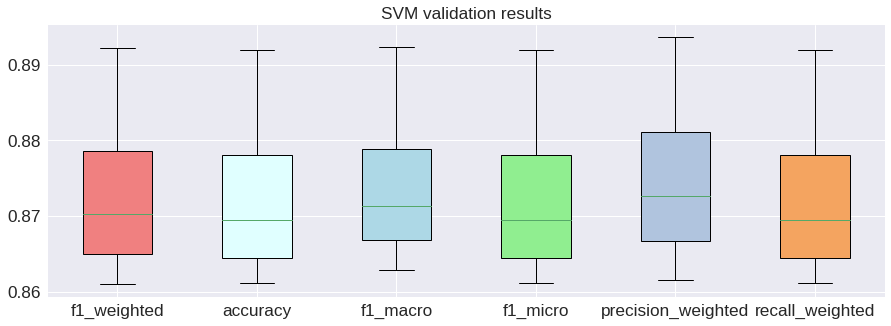

In [61]:
svm_scores_val, svm_scores_train, svm_scores_others = print_cross_validation(svm_opt, "SVM", X_train_scal, Y_train)

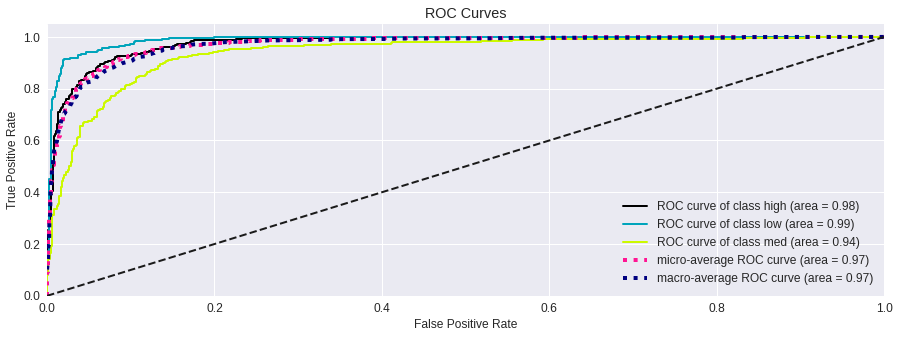

In [62]:
test_pred_proba_svm = svm_opt.predict_proba(X_test_scal)
skplt.metrics.plot_roc_curve(Y_test.values, test_pred_proba_svm)
plt.show()

In [63]:
print(metrics.classification_report(Y_test, test_pred_svm))

              precision    recall  f1-score   support

        high       0.87      0.83      0.85       292
         low       0.92      0.93      0.93       385
         med       0.83      0.85      0.84       434

    accuracy                           0.87      1111
   macro avg       0.88      0.87      0.87      1111
weighted avg       0.87      0.87      0.87      1111



<AxesSubplot:>

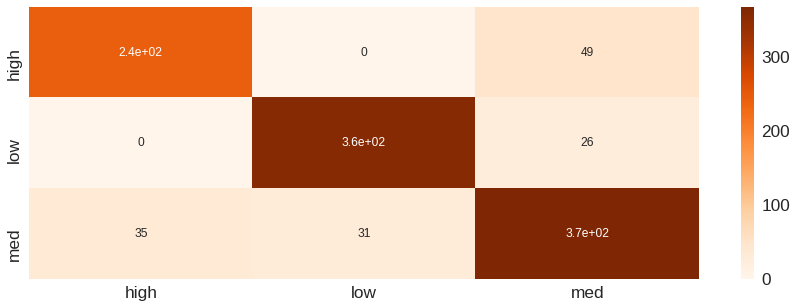

In [64]:
cf_matrix_svm = metrics.confusion_matrix(Y_test, test_pred_svm)
df_cm_svm = pd.DataFrame(cf_matrix_svm, columns=np.unique(Y_test), index = np.unique(Y_test))
sns.heatmap(df_cm_svm, annot=True, cmap='Oranges')

## AdaBoost

In [65]:
random.seed(42)

In [66]:
param_dict = {"n_estimators": [2, 5, 8, 10],
              "algorithm": ["SAMME", "SAMME.R"],
              "learning_rate": [0.1, 0.3, 0.5, 0.8, 1]
              }
ab = AdaBoostClassifier(base_estimator=dt_opt)
search_ab, ab_opt = random_search(ab, param_dict, score_fun, X_train, Y_train, cv=K, n_iter=32)

In [67]:
print("Best hyperparameters configuration")
display(search_ab.best_params_)
print(search_ab.best_score_)

Best hyperparameters configuration


{'n_estimators': 10, 'learning_rate': 0.1, 'algorithm': 'SAMME'}

0.8804158910217375


In [68]:
test_pred_ab = ab_opt.predict(X_test)
#compute the performance of the model
print(metrics.classification_report(Y_test, test_pred_ab))

              precision    recall  f1-score   support

        high       0.87      0.78      0.83       292
         low       0.93      0.93      0.93       385
         med       0.81      0.86      0.83       434

    accuracy                           0.86      1111
   macro avg       0.87      0.86      0.86      1111
weighted avg       0.87      0.86      0.86      1111



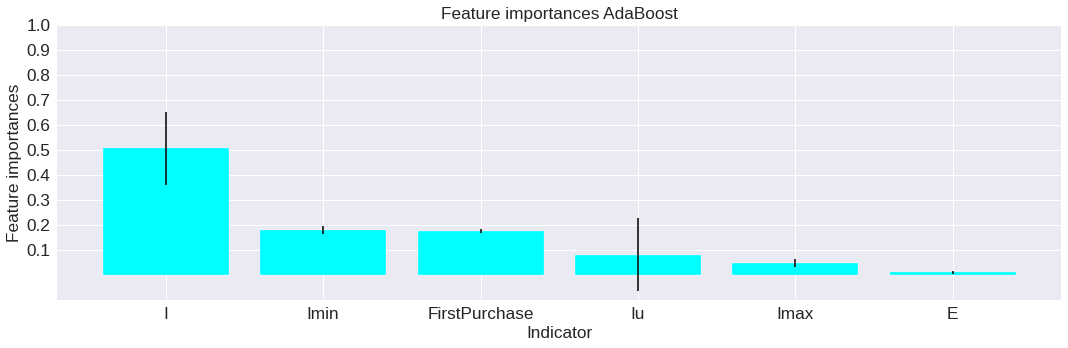

In [69]:
std = np.std([tree.feature_importances_ for tree in ab_opt.estimators_], axis=0)
feature_importances_ab = pd.DataFrame({
    "Indicator": X_train.columns,
    "FeatureImportance": ab_opt.feature_importances_,
    "Std": std
})
feature_importances_ab = feature_importances_ab.sort_values("FeatureImportance", ascending=False)

plt.bar(feature_importances_ab["Indicator"], feature_importances_ab["FeatureImportance"],
        color="cyan", yerr=feature_importances_ab["Std"], align="center")

plt.xlabel("Indicator")
plt.ylabel("Feature importances")
plt.yticks(np.arange(0.1, 1.1, 0.1))
plt.title("Feature importances AdaBoost")
plt.tight_layout()
plt.show()

(Mean) fit_time                                : 0.13683485984802246
(Mean) score_time                              : 0.04350090026855469
(Mean) val_f1_weighted                         : 0.8788808479235283
(Mean) train_f1_weighted                       : 0.9262221877130934
(Mean) val_accuracy                            : 0.8784245186711699
(Mean) train_accuracy                          : 0.9258970023234191
(Mean) val_f1_macro                            : 0.8778851134753894
(Mean) train_f1_macro                          : 0.9261485621510583
(Mean) val_f1_micro                            : 0.8784245186711699
(Mean) train_f1_micro                          : 0.9258970023234191
(Mean) val_precision_weighted                  : 0.8830123608181354
(Mean) train_precision_weighted                : 0.9283986092067081
(Mean) val_recall_weighted                     : 0.8784245186711699
(Mean) train_recall_weighted                   : 0.9258970023234191


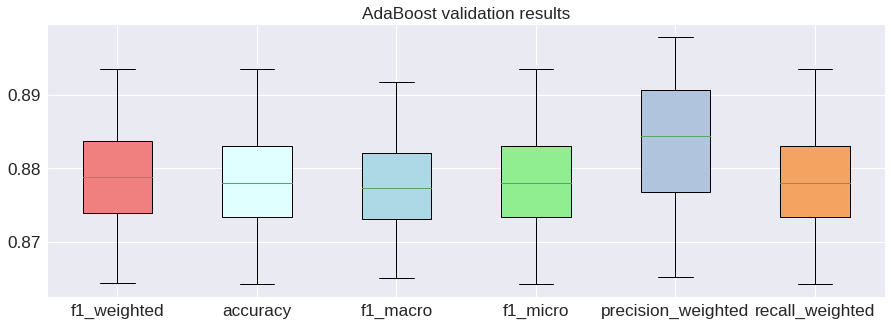

In [70]:
ab_scores_val, ab_scores_train, ab_scores_others = print_cross_validation(ab_opt, "AdaBoost", X_train, Y_train)

<AxesSubplot:>

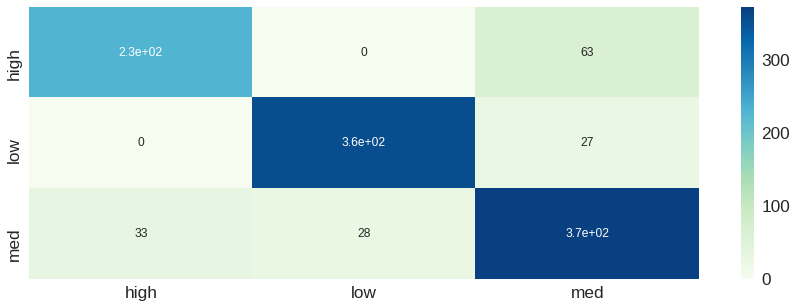

In [71]:
cf_matrix_ab = metrics.confusion_matrix(Y_test, test_pred_ab)
df_cm_ab = pd.DataFrame(cf_matrix_ab, columns=np.unique(Y_test), index = np.unique(Y_test))
sns.heatmap(df_cm_ab, annot=True, cmap='GnBu')

# Comparison of models results

In [72]:
models_names = ["Decision Tree", "Gaussian Naive Bayes", "Random Forest", "KNN", "SVM", "AdaBoost"]

In [73]:
import plotly.express as px

import plotly.graph_objects as go

def radar_plot(df_scores, models_names, mode="lines+markers"):
    categories = list(df_scores.columns)

    fig = go.Figure()

    for model_name in models_names:
        fig.add_trace(go.Scatterpolar(
            r=df_scores[df_scores.index == model_name].values.tolist()[0],
            theta=categories,
            name=model_name,
            mode=mode
        ))

    fig.update_layout(
      polar=dict(
        radialaxis=dict(
          visible=True,
        )),
      showlegend=True
    )

    fig.show()

### Timing

In [74]:
# Decision Tree
df_scores_others = pd.DataFrame(dt_scores_others, index=[0])
# Gaussian Naive Bayes
df_scores_others = df_scores_others.append(gnb_scores_others, ignore_index=True)
# Random Forest
df_scores_others = df_scores_others.append(rf_scores_others, ignore_index=True)
# K-Nearest Neighbors
df_scores_others = df_scores_others.append(knn_scores_others, ignore_index=True)
# Support Vector Machine
df_scores_others = df_scores_others.append(svm_scores_others, ignore_index=True)
# AdaBoost
df_scores_others = df_scores_others.append(ab_scores_others, ignore_index=True)

df_scores_others = df_scores_others.set_index("Model")
display(df_scores_others)

fit_time  score_time
Model                                     
Decision Tree         0.015173    0.037616
Gaussian Naive Bayes  0.010078    0.031680
Random Forest         0.609988    0.069641
KNN                   0.005949    0.055970
SVM                   0.702317    0.075547
AdaBoost              0.136835    0.043501

/home/fabsam/miniconda3/envs/py3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


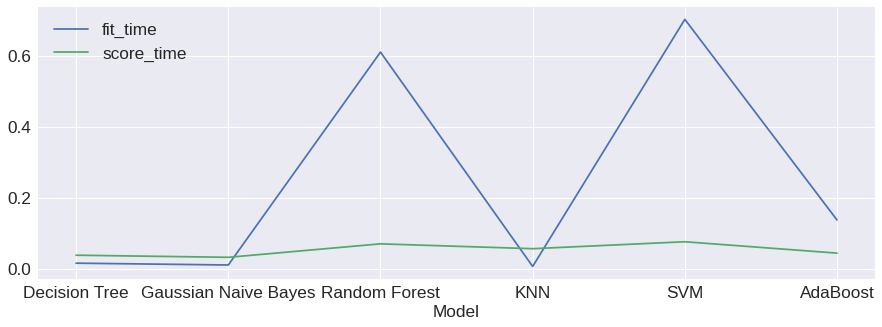

In [75]:
df_scores_others.plot()
plt.show()

### Training

In [76]:
# Decision Tree
df_scores_train = pd.DataFrame(dt_scores_train, index=[0])
# Gaussian Naive Bayes
df_scores_train = df_scores_train.append(gnb_scores_train, ignore_index=True)
# Random Forest
df_scores_train = df_scores_train.append(rf_scores_train, ignore_index=True)
# K-Nearest Neighbors
df_scores_train = df_scores_train.append(knn_scores_train, ignore_index=True)
# Support Vector Machine
df_scores_train = df_scores_train.append(svm_scores_train, ignore_index=True)
# AdaBoost
df_scores_train = df_scores_train.append(ab_scores_train, ignore_index=True)

df_scores_train = df_scores_train.set_index("Model")
display(df_scores_train)

train_f1_weighted  train_accuracy  train_f1_macro  \
Model                                                                     
Decision Tree                  0.887927        0.887430        0.887956   
Gaussian Naive Bayes           0.672521        0.680688        0.684468   
Random Forest                  0.924942        0.924610        0.924681   
KNN                            0.999743        0.999743        0.999767   
SVM                            0.894747        0.894506        0.896506   
AdaBoost                       0.926222        0.925897        0.926149   

                      train_f1_micro  train_precision_weighted  \
Model                                                            
Decision Tree               0.887430                  0.890427   
Gaussian Naive Bayes        0.680688                  0.691495   
Random Forest               0.924610                  0.926026   
KNN                         0.999743                  0.999743   
SVM                         0.894506                  0.895281   
AdaBoost                    0.925897                  0.928399   

                      train_recall_weighted  
Model                                        
Decision Tree                      0.887430  
Gaussian Naive Bayes               0.680688  
Random Forest                      0.924610  
KNN                                0.999743  
SVM                                0.894506  
AdaBoost                           0.925897

/home/fabsam/miniconda3/envs/py3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


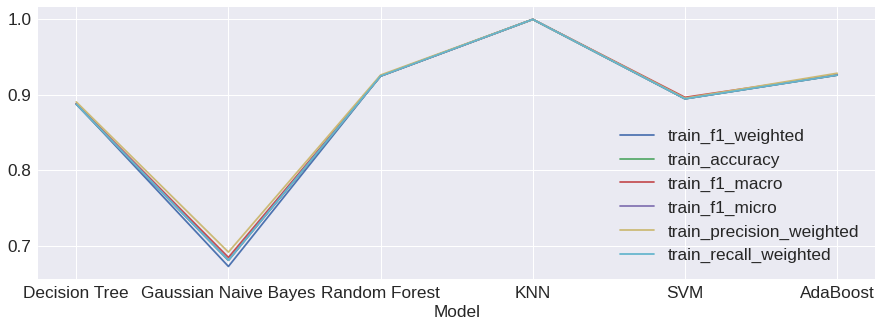

In [77]:
df_scores_train.plot()
plt.show()

In [78]:
radar_plot(df_scores_train, models_names)

### Validation

In [79]:
# Decision Tree
df_scores_val = pd.DataFrame(dt_scores_val, index=[0])
# Gaussian Naive Bayes
df_scores_val = df_scores_val.append(gnb_scores_val, ignore_index=True)
# Random Forest
df_scores_val = df_scores_val.append(rf_scores_val, ignore_index=True)
# K-Nearest Neighbors
df_scores_val = df_scores_val.append(knn_scores_val, ignore_index=True)
# Support Vector Machine
df_scores_val = df_scores_val.append(svm_scores_val, ignore_index=True)
# AdaBoost
df_scores_val = df_scores_val.append(ab_scores_val, ignore_index=True)

df_scores_val = df_scores_val.set_index("Model")
display(df_scores_val)

val_f1_weighted  val_accuracy  val_f1_macro  \
Model                                                               
Decision Tree                0.862130      0.861442      0.862538   
Gaussian Naive Bayes         0.668467      0.676953      0.680550   
Random Forest                0.884026      0.883439      0.884057   
KNN                          0.845209      0.845227      0.846974   
SVM                          0.873399      0.873019      0.874441   
AdaBoost                     0.878881      0.878425      0.877885   

                      val_f1_micro  val_precision_weighted  \
Model                                                        
Decision Tree             0.861442                0.866357   
Gaussian Naive Bayes      0.676953                0.689649   
Random Forest             0.883439                0.886614   
KNN                       0.845227                0.846171   
SVM                       0.873019                0.875125   
AdaBoost                  0.878425                0.883012   

                      val_recall_weighted  
Model                                      
Decision Tree                    0.861442  
Gaussian Naive Bayes             0.676953  
Random Forest                    0.883439  
KNN                              0.845227  
SVM                              0.873019  
AdaBoost                         0.878425

/home/fabsam/miniconda3/envs/py3.7/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning:

FixedFormatter should only be used together with FixedLocator



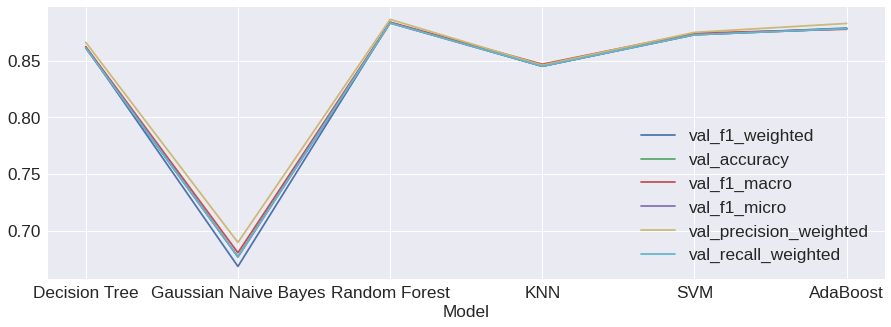

In [80]:
df_scores_val.plot()
plt.show()

In [81]:
radar_plot(df_scores_val, models_names)

In [82]:
df_scores_diff = df_scores_train.sub(df_scores_val.values, axis=0)
df_scores_diff.columns = [k.replace("train_", "diff_") for k in df_scores_diff.columns]

In [83]:
radar_plot(df_scores_diff, models_names, mode='markers+lines')

In [84]:
df = df_scores_val.reset_index().merge(df_scores_others.reset_index())

In [85]:
import plotly.express as px

fig = go.Figure(go.Barpolar(
    r=df["val_f1_weighted"].values.tolist(),
    theta=df["Model"].tolist(),
    width=df["fit_time"],
    opacity=0.8,
    marker_color=["red", 'green', 'blue', 'yellow', 'orange', 'cyan']
))

fig.update_layout(
    title="Validation results and fit time",
    polar=dict(
        radialaxis=dict(
          visible=True,
        ))
)
fig.show()
             

In [86]:
df = df.reset_index().merge(df_scores_train.reset_index())

In [87]:
fig = go.Figure(px.scatter(df, x="train_f1_weighted", y="val_f1_weighted", color="Model", size="score_time"))
fig.update_layout(
    title="Training and Validation f1_weighted scores and score time",
)
fig.show()

## Miclassifications on test set

In [88]:
print("|Test set| = ", len(Y_test))

|Test set| =  1111


In [89]:
misclass_rf = Y_test != test_pred_rf
err_rf = X_test[misclass_rf]
print(misclass_rf.value_counts())

misclass_ab = Y_test != test_pred_ab
err_ab = X_test[misclass_ab]
print(misclass_ab.value_counts())

misclass_svm = Y_test != test_pred_svm
err_svm = X_test[misclass_svm]
print(misclass_svm.value_counts())

False    958
True     153
Name: Spending, dtype: int64
False    960
True     151
Name: Spending, dtype: int64
False    970
True     141
Name: Spending, dtype: int64


In [90]:
misclass_df = err_rf.merge(err_ab, how='inner').merge(err_svm, how='inner')

In [91]:
display(misclass_df.head())
print(misclass_df.describe())

I  Iu  Imax  Imin         E  FirstPurchase
0  139  14    60    37  3.681881            196
1  110  12    62     6  3.546594            241
2  406  43   260    42  5.360902            329
3   84  11    42    12  3.418296            338
4  144  16    50    44  3.932138            274

                I        Iu        Imax        Imin          E  FirstPurchase
count   93.000000  93.00000   93.000000   93.000000  93.000000      93.000000
mean   122.462366  14.16129   57.978495   23.387097   3.275677     247.602151
std    107.167642  12.24238   49.385788   24.660756   1.241241      93.039512
min      8.000000   1.00000    4.000000    4.000000   0.000000      28.000000
25%     48.000000   5.00000   24.000000    8.000000   2.321928     206.000000
50%     92.000000  11.00000   50.000000   12.000000   3.418296     274.000000
75%    148.000000  18.00000   66.000000   32.000000   4.142664     322.000000
max    530.000000  65.00000  260.000000  142.000000   5.952087     373.000000
